### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Welcome\AppData\Local\Temp\ipykernel_27760\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Daily AI Agent News - March 2025',
  'url': 'https://aiagentstore.ai/ai-agent-news/2025-march',
  'content': 'March 3, 2025 — Today marked significant advancements in AI agent development, with major players unveiling cutting-edge innovations. At Mobile World Congress 2025, Samsung showcased its expanded Galaxy AI ecosystem, including the Galaxy S25 Edge—the slimmest device in the series—and Project Moohan, its first XR headset. The company highlighted AI-driven health features like Energy Score and Sleep Insights, which integrate with SmartThings for personalized wellness management. [...] OpenAI’s o3 model continues to dominate scientific problem-solving benchmarks, while Meta’s AI-driven productivity tools reportedly reduced HR case resolution times by 36%. Meanwhile, Elon Musk’s Grok 3 entered final testing, promising unprecedented reasoning capabilities for consumer-facing applications. [...] Meanwhile, Sam Altman highlighted OpenAI\'s recent scientific milestones, cal

In [9]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [12]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=llm.bind_tools(tools)

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, which is for scientific papers in fields like Physics and Computer Science. But the user is asking for news, not academic papers. So maybe arxiv isn\'t the best fit here.\n\nNext, the wikipedia function. Wikipedia does have information on AI, but it\'s more of an encyclopedia. Recent news might not be up to date on Wikipedia since it takes time for articles to be updated. Plus, Wikipedia entries are more about established knowledge rather than the latest news.\n\nThen there\'s the tavily_search_results_json function, which is described as a search engine optimized for current events. That sounds perfect for recent news. The user wants the latest updates, so using a search engine that can fetch current results makes sense.\n\nSo I should use tavily_search_resul

In [14]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'nrre4b8nw',
  'type': 'tool_call'}]

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

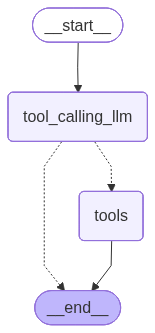

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (s2gggg1xk)
 Call ID: s2gggg1xk
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (41p6th7nf)
 Call ID: 41p6th7nf
  Args:
    query: top 10 AI news March 3 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weekly AI News: 3 March 2025 - AIforBusiness.net", "url": "https://www.linkedin.com/pulse/weekly-ai-news-3-march-2025-aiforbusinessnet-johan-steyn-qrumf", "content": "This week’s AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-edge model with enhanced intuition and emotional intelligence. While its capabilities push AI closer to human-like perception, its high computational demands raise concerns about accessibility, particularly for smaller busine

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (rfjqg01e8)
 Call ID: rfjqg01e8
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
